# Рекомендация тарифов

### Описание проекта:
Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».
В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

### Цель проекта:
Построить модель для задачи классификации с максимально большим значением *accuracy*, которая выберет подходящий тариф. Нужно довести долю правильных ответов по крайней мере до 0.75. Проверить *accuracy* на тестовой выборке.

### Описание данных
<b>Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:</b>
<ul style="border:solid black 2px; padding: 20px">
    <b>Таблица users_behavior:</b>
    <li><i>calls</i> — количество звонков</li>
    <li><i>minutes</i> — суммарная длительность звонков в минутах,</li>
    <li><i>messages</i> — количество sms-сообщений,</li>
    <li><i>mb_used</i> — израсходованный интернет-трафик в Мб,</li>
    <li><i>is_ultra</i> — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).</li>
</ul>

## Откроем и изучим файл

In [ ]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics 
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('/datasets/users_behavior.csv')

In [ ]:
display(df)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
...,...,...,...,...,...
3209,122.0,910.98,20.0,35124.90,1
3210,25.0,190.36,0.0,3275.61,0
3211,97.0,634.44,70.0,13974.06,0
3212,64.0,462.32,90.0,31239.78,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
calls       3214 non-null float64
minutes     3214 non-null float64
messages    3214 non-null float64
mb_used     3214 non-null float64
is_ultra    3214 non-null int64
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [ ]:
print(df.duplicated().sum())

0


In [ ]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


In [ ]:
df['is_ultra'].mean()

0.30647168637212197

<b>Почти 70% пользователей используют тариф "Смарт"</b>

In [ ]:
df.groupby('is_ultra')['calls'].agg(['count','mean','median'])

,count,mean,median
is_ultra,,,
0,2229,58.463437,60.0
1,985,73.392893,74.0


In [ ]:
df.groupby('is_ultra')['minutes'].agg(['count','mean','median'])

,count,mean,median
is_ultra,,,
0,2229,405.942952,410.56
1,985,511.224569,502.55


In [ ]:
df.groupby('is_ultra')['messages'].agg(['count','mean','median'])

,count,mean,median
is_ultra,,,
0,2229,33.384029,28.0
1,985,49.363452,38.0


In [ ]:
df.groupby('is_ultra')['mb_used'].agg(['count','mean','median'])

,count,mean,median
is_ultra,,,
0,2229,16208.466949,16506.93
1,985,19468.823228,19308.01


In [ ]:
df

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
...,...,...,...,...,...
3209,122.0,910.98,20.0,35124.90,1
3210,25.0,190.36,0.0,3275.61,0
3211,97.0,634.44,70.0,13974.06,0
3212,64.0,462.32,90.0,31239.78,0


<b>Рассчитаем зависимость между признаками</b>

In [ ]:
corrMatrix = df[['calls','minutes','messages','mb_used','is_ultra']].corr()

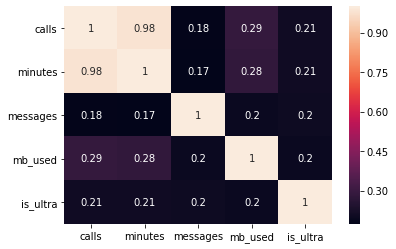

In [ ]:
sns.heatmap(corrMatrix, annot=True)
plt.show()

<b>Действительно наблюдается сильная взаимосвязь между <i>'calls'</i> и <i>'minutes'</i>.</b>

## Разобьем данные на выборки

<b>Разобьем данные на три выборки в соотношении 3:1:1. Обучающая выборка будет содержать в себе 60% данных, валидационная 20% и тестовая 20%.</b>

In [ ]:
df_train, df_valid = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
df_train, df_test = train_test_split(df_train, test_size=0.25, random_state=1)

In [ ]:
0.25 * 0.8

0.2

In [ ]:
features_train = df_train.drop(['is_ultra', 'minutes'], axis=1)
target_train  = df_train['is_ultra']

In [ ]:
features_valid = df_valid.drop(['is_ultra', 'minutes'], axis=1)
target_valid  = df_valid['is_ultra']

In [ ]:
test_features = df_test.drop(['is_ultra', 'minutes'], axis=1)
test_target  = df_test['is_ultra']

<b>Убедимся, что разбили правильно.</b>

In [ ]:
print(features_train.shape)
print(target_train.shape)
print(features_valid.shape)
print(target_valid.shape)
print(test_features.shape)
print(test_target.shape)

(1928, 3)
(1928,)
(643, 3)
(643,)
(643, 3)
(643,)


In [ ]:
len(df)

3214

In [ ]:
len(features_train) + len(features_valid) + len(test_features)

3214

In [ ]:
display(features_train)

,calls,messages,mb_used
2009,32.0,25.0,25587.59
2175,32.0,13.0,8507.87
1249,98.0,74.0,7844.43
1343,40.0,45.0,14359.01
367,61.0,21.0,16578.27
...,...,...,...
2372,180.0,109.0,19423.77
2542,54.0,59.0,15811.56
780,72.0,25.0,14696.31
1776,52.0,46.0,20741.66


In [ ]:
display(target_train)

2009    0
2175    0
1249    1
1343    0
367     0
       ..
2372    1
2542    0
780     0
1776    0
1199    0
Name: is_ultra, Length: 1928, dtype: int64

In [ ]:
display(features_valid)

,calls,messages,mb_used
506,46.0,35.0,11428.54
2513,39.0,0.0,20480.11
354,39.0,0.0,19998.80
1080,36.0,19.0,23525.07
2389,35.0,52.0,35177.94
...,...,...,...
366,64.0,36.0,17413.75
1952,100.0,31.0,17726.01
29,50.0,44.0,9998.83
2682,0.0,23.0,21934.04


In [ ]:
display(target_valid)

506     0
2513    0
354     0
1080    1
2389    1
       ..
366     0
1952    1
29      1
2682    1
22      1
Name: is_ultra, Length: 643, dtype: int64

In [ ]:
display(test_features)

,calls,messages,mb_used
365,20.0,23.0,26720.17
1571,81.0,106.0,20895.15
2075,87.0,22.0,26271.47
2269,79.0,9.0,16602.13
1120,24.0,77.0,13292.23
...,...,...,...
2936,59.0,31.0,19638.50
2674,8.0,34.0,10879.86
109,35.0,0.0,9545.00
897,29.0,30.0,19527.95


In [ ]:
display(test_target)

365     1
1571    0
2075    1
2269    0
1120    0
       ..
2936    0
2674    0
109     1
897     0
1492    0
Name: is_ultra, Length: 643, dtype: int64

### Вывод по разделу
<b>Методом <i>train_test_split()</i> разбили данные на три выборки: обучающую(60%), валидационную(20%), тестовую(20%).</b>

## Исследуем модели

<b>Модель дерево решений</b>

<b>Попробуем применить GridSearchCV для нахождения гиперпараметров.</b>

In [ ]:
splitter = ['best','random']
max_depth = [4,5,6,7,8,9,10,15]
min_samples_split = [2,3,4,5,6,7,8,9]
min_samples_leaf = [2,3,4,5,6,7,8,9]
param_grid = {'splitter': splitter,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
gs_tree = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid)
gs_tree.fit(features_train,target_train)
gs_tree.best_params_

{'max_depth': 4,
 'min_samples_leaf': 9,
 'min_samples_split': 2,
 'splitter': 'best'}

In [ ]:
model_tree_gs = DecisionTreeClassifier(random_state=42, max_depth=4, min_samples_leaf=9,splitter='best')
model_tree_gs.fit(features_train, target_train) 
predictions_valid_tree_gs = model_tree_gs.predict(features_valid)
result_tree_gs = accuracy_score(target_valid, predictions_valid_tree_gs)
print("Accuracy модели дерево решений на валидационной выборке:",result_tree_gs)

Accuracy модели дерево решений на валидационной выборке: 0.8055987558320373


<b>Переберем гиперпараметры циклом, наилучшим получился этот вариант.</b>

In [ ]:
# for depth in range(1,15):
#     for leaf in range(1,8):
#         for split in range(2,8):
#             model_tree = DecisionTreeClassifier(random_state=42, max_depth=depth, min_samples_leaf=leaf,min_samples_split=split)
#             model_tree.fit(features_train, target_train) 
#             predictions_valid_tree = model_tree.predict(features_valid)
#             result_tree = accuracy_score(target_valid, predictions_valid_tree)
#             print("depth,leaf,split =", depth,leaf,split, ": ", end='')
#             print(result_tree)

In [ ]:
model_tree = DecisionTreeClassifier(random_state=42, max_depth=6, min_samples_leaf=7)
model_tree.fit(features_train, target_train) 
predictions_valid_tree = model_tree.predict(features_valid)
result_tree = accuracy_score(target_valid, predictions_valid_tree)
print("Accuracy модели дерево решений на валидационной выборке:",result_tree)

Accuracy модели дерево решений на валидационной выборке: 0.8164852255054432


<b>Модель случайный лес</b>

<b>Попробуем применить GridSearchCV для нахождения гиперпараметров.</b>

In [ ]:
n_estimators = [15,50,60,70]
max_depth = [9,12,15]
min_samples_split = [2,4,6,8]
min_samples_leaf = [1,3,5,7,9]
param_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
gs = GridSearchCV(RandomForestClassifier(random_state=42), param_grid)
gs.fit(features_train,target_train)
gs.best_params_

{'max_depth': 9,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 60}

In [ ]:
model_forest_gr = RandomForestClassifier(random_state=42, n_estimators=60, max_depth=9,min_samples_leaf=5) 
model_forest_gr.fit(features_train,target_train)
predictions_valid_forest_gr = model_forest_gr.predict(features_valid)
result_forest_gr = accuracy_score(target_valid, predictions_valid_forest_gr)

print("Accuracy модели случайный лес на валидационной выборке:",result_forest_gr)

Accuracy модели случайный лес на валидационной выборке: 0.8149300155520995


<b>Поиск конечно осуществляется не быстро, но все же подобрать гиперпараметры получается.</b>

<b>Здесь я попробовал сам перебрать гиперпараметры, наилучшим получился этот вариант.</b>

In [ ]:
# best_model = None
# best_result = 0
# for est in range(1, 15):
#     for depth in range(1,10):
#         for leaf in range(1,8):
#             for split in range(2,8):
#                 model_forest = RandomForestClassifier(random_state=42, n_estimators=est, max_depth=depth,min_samples_leaf=leaf,min_samples_split=split) 
#                 model_forest.fit(features_train,target_train) 
#                 predictions_valid_forest = model_forest.predict(features_valid)
#                 result_forest = accuracy_score(target_valid, predictions_valid_forest)
#                 if result_forest > best_result:
#                     best_model = model_forest
#                     best_result = result_forest
#                 print("Accuracy наилучшей модели на валидационной выборке:", est, depth,leaf,split, best_result)

In [ ]:
model_forest = RandomForestClassifier(random_state=42, n_estimators=13, max_depth=9,min_samples_leaf=2,min_samples_split=2) 
model_forest.fit(features_train,target_train)
predictions_valid_forest = model_forest.predict(features_valid)
result_forest = accuracy_score(target_valid, predictions_valid_forest)

print("Accuracy модели случайный лес на валидационной выборке:",result_forest)

Accuracy модели случайный лес на валидационной выборке: 0.8289269051321928


<b>Модель логистическая регрессия</b>

<b>Попробуем применить GridSearchCV к логистической модели</b>

In [ ]:
penalty = ['l1','l2']
C = [1,2,3,4,5,6,7,8,9]
max_iter = [50,100,150,200]
param_grid = {'penalty': penalty,
               'C': C,
               'max_iter': max_iter}
gs_reg = GridSearchCV(LogisticRegression(random_state=42), param_grid)
gs_reg.fit(features_train,target_train)
gs_reg.best_params_

{'C': 3, 'max_iter': 50, 'penalty': 'l1'}

In [ ]:
model_reg = LogisticRegression(C=3,random_state=42, penalty='l1',max_iter=50) 
model_reg.fit(features_train,target_train)
predictions_valid_reg = model_reg.predict(features_valid)
result_reg = accuracy_score(target_valid, predictions_valid_reg)

print("Accuracy модели логистической регрессии на валидационной выборке:", result_reg)

Accuracy модели логистической регрессии на валидационной выборке: 0.7573872472783826


### Вывод по разделу

1. <b>Построили 3 модели: дерево решений, случайный лес и логистическая регрессия. 
2. Попробовал использовать подбор гиперпараметров методом GridSearchCV, а также обычными циклами for. Результаты получились немного разными, возможно нужно более детально разобрать GridSearchCV. 
3. Также добились доли правильных ответов больше 0.75.</b><br>
<table border="5" width="300" cellpadding="5" cellspasing="2" bordercolor="#000000" align="left">
    <tr>
        <th>Модель</th>
        <th>Доля правильных ответов</th>
    </tr>
    <tr>
        <th>Дерево решений</th>
        <th>0.8164</th>
    </tr>
     <tr>
        <th>Случайный лес</th>
        <th>0.8289</th>
    </tr>
    <tr>
        <th>Логистическая регрессия</th>
        <th>0.7573</th>
    </tr>
</table>

## Проверим модель на тестовой выборке

<b>Объединим обучающую выборку и валидационную</b>

In [ ]:
display(features_train)

,calls,messages,mb_used
2009,32.0,25.0,25587.59
2175,32.0,13.0,8507.87
1249,98.0,74.0,7844.43
1343,40.0,45.0,14359.01
367,61.0,21.0,16578.27
...,...,...,...
2372,180.0,109.0,19423.77
2542,54.0,59.0,15811.56
780,72.0,25.0,14696.31
1776,52.0,46.0,20741.66


In [ ]:
display(features_valid)

,calls,messages,mb_used
506,46.0,35.0,11428.54
2513,39.0,0.0,20480.11
354,39.0,0.0,19998.80
1080,36.0,19.0,23525.07
2389,35.0,52.0,35177.94
...,...,...,...
366,64.0,36.0,17413.75
1952,100.0,31.0,17726.01
29,50.0,44.0,9998.83
2682,0.0,23.0,21934.04


In [ ]:
new_features = pd.concat([features_train, features_valid])
new_target = pd.concat([target_train, target_valid])

In [ ]:
display(new_features)

,calls,messages,mb_used
2009,32.0,25.0,25587.59
2175,32.0,13.0,8507.87
1249,98.0,74.0,7844.43
1343,40.0,45.0,14359.01
367,61.0,21.0,16578.27
...,...,...,...
366,64.0,36.0,17413.75
1952,100.0,31.0,17726.01
29,50.0,44.0,9998.83
2682,0.0,23.0,21934.04


In [ ]:
display(new_target)

2009    0
2175    0
1249    1
1343    0
367     0
       ..
366     0
1952    1
29      1
2682    1
22      1
Name: is_ultra, Length: 2571, dtype: int64

In [ ]:
len(df) - len(new_features)

643

In [ ]:
model_tree.fit(new_features, new_target) 
test_predictions_tree = model_tree.predict(test_features)
accuracy_tree_test = accuracy_score(test_target, test_predictions_tree)

print('Accuracy модели дерева решений на тестовой выборке:',accuracy_tree_test)

Accuracy модели дерева решений на тестовой выборке: 0.8118195956454122


In [ ]:
model_forest.fit(new_features, new_target) 
test_predictions_forest = model_forest.predict(test_features)
accuracy_forest_test = accuracy_score(test_target, test_predictions_forest)

print('Accuracy модели случайного леса на тестовой выборке:',accuracy_forest_test)

Accuracy модели случайного леса на тестовой выборке: 0.8227060653188181


In [ ]:
model_reg.fit(new_features, new_target) 
test_predictions_reg = model_reg.predict(test_features)
accuracy_reg_test = accuracy_score(test_target, test_predictions_reg)

print("Accuracy модели логистической регрессии на тестовой выборке:", accuracy_reg_test)

Accuracy модели логистической регрессии на тестовой выборке: 0.7620528771384136


### Вывод по разделу
<b>На тестовой выборке результаты схожи с предыдущими результатами. Стоит заметить, что модели "Логистическая регрессия" и "Дерево решений" проигрывают по доле правильных ответов модели "Случайный лес".</b>

## (бонус) Проверьте модели на адекватность

<b>Рассчитаем Точность и Полноту модели, а также построим Матрицу неточностей.</b>

<b>Модель дерево решений</b>

In [ ]:
print(metrics.classification_report(test_target,test_predictions_tree))

              precision    recall  f1-score   support

           0       0.82      0.95      0.88       455
           1       0.79      0.48      0.60       188

    accuracy                           0.81       643
   macro avg       0.80      0.72      0.74       643
weighted avg       0.81      0.81      0.80       643



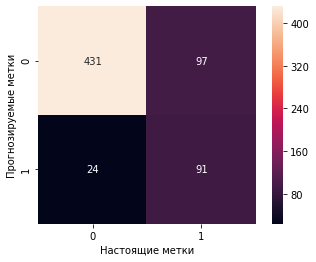

In [ ]:
mat_tree = confusion_matrix(test_target,test_predictions_tree)
sns.heatmap(mat_tree.T, square=True, annot=True, fmt='d', cbar=True)
plt.xlabel('Настоящие метки')
plt.ylabel('Прогнозируемые метки')
plt.show()

In [ ]:
455/155

2.935483870967742

<b>Классы по размеру отличаются почти в 3 раза. Средняя точность по всем классам равна 80%, т.е. около 80% положительных решений правильные. Что касается полноты, то она составляет 70%.</b>

<b>Модель случайный лес</b>

In [ ]:
print(metrics.classification_report(test_target,test_predictions_forest))

              precision    recall  f1-score   support

           0       0.83      0.94      0.88       455
           1       0.78      0.54      0.64       188

    accuracy                           0.82       643
   macro avg       0.81      0.74      0.76       643
weighted avg       0.82      0.82      0.81       643



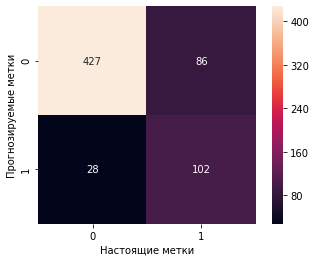

In [ ]:
mat_forest = confusion_matrix(test_target,test_predictions_forest)
sns.heatmap(mat_forest.T, square=True, annot=True, fmt='d', cbar=True)
plt.xlabel('Настоящие метки')
plt.ylabel('Прогнозируемые метки')
plt.show()

<b>Средняя точность по всем классам равна 80%, т.е. около 80% положительных решений правильные. Что касается полноты, то она составляет 73%. Схожие показатели с моделью дерево решений.</b>

<b>Модель логистическая регрессия</b>

In [ ]:
print(metrics.classification_report(test_target,test_predictions_reg))

              precision    recall  f1-score   support

           0       0.76      0.98      0.85       455
           1       0.82      0.24      0.37       188

    accuracy                           0.76       643
   macro avg       0.79      0.61      0.61       643
weighted avg       0.77      0.76      0.71       643



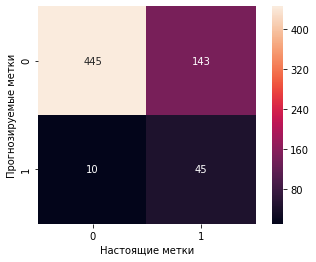

In [ ]:
mat_reg = confusion_matrix(test_target,test_predictions_reg)
sns.heatmap(mat_reg.T, square=True, annot=True, fmt='d', cbar=True)
plt.xlabel('Настоящие метки')
plt.ylabel('Прогнозируемые метки')
plt.show()

<b>Средняя точность по всем классам равна 78%, т.е. около 78% положительных решений правильные. Что касается полноты, то она составляет 61%. По сравнению с остальными моделями показатели намного хуже.</b>

In [ ]:
df['is_ultra'].value_counts(normalize=True)

0    0.693528
1    0.306472
Name: is_ultra, dtype: float64

In [ ]:
dummy = DummyClassifier(strategy='most_frequent').fit(new_features,new_target)
dummy_pred = dummy.predict(test_features)
result_dummy = accuracy_score(test_target,dummy_pred)
print("Accuracy модели", result_dummy)

Accuracy модели 0.7076205287713841


<b>Судя по accuracy этой модели, мы неплохо обучили наши 3 модели.</b>

### Вывод
1. Построили 3 модели: дерево решений, случайный лес, логистическая регрессия.
2. Сравнили показатели метрики качества, которые оценивают качество работы модели.
3. Из трех моделей предпочтение стоит отдать модели Случайный лес, так как там наиболее большая точность. Так же стоит проверить модель на более реливантной выборке, так как сейчас соотношение классов почти 3:1. 
<br>
<table border="5" width="300" cellpadding="5" cellspasing="2" bordercolor="#000000" align="left">
    <tr>
        <th>Модель</th>
        <th>Доля правильных ответов</th>
        <th>Точность</th>
        <th>Полнота</th>
    </tr>
    <tr>
        <th>Дерево решений</th>
        <th>0.8118</th>
        <th>0.8</th>
        <th>0.72</th>
    </tr>
     <tr>
        <th>Случайный лес</th>
        <th>0.8227</th>
        <th>0.81</th>
        <th>0.74</th>
    </tr>
    <tr>
        <th>Логистическая регрессия</th>
        <th>0.7620</th>
        <th>0.79</th>
        <th>0.61</th>
    </tr>
</table>

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x] Jupyter Notebook открыт
- [x] Весь код исполняется без ошибок
- [x] Ячейки с кодом расположены в порядке исполнения
- [x] Выполнено задание 1: данные загружены и изучены
- [x] Выполнено задание 2: данные разбиты на три выборки
- [x] Выполнено задание 3: проведено исследование моделей
    - [x] Рассмотрено больше одной модели
    - [x] Рассмотрено хотя бы 3 значения гипепараметров для какой-нибудь модели
    - [x] Написаны выводы по результатам исследования
- [x] Выполнено задание 4: Проведено тестирование
- [x] Удалось достичь accuracy не меньше 0.75
